In [20]:
from matplotlib import pyplot as plt
%matplotlib inline
import h5py
import seaborn
import numpy as np
import os
import tensorflow as tf
from sklearn.metrics import pairwise_distances
import sys
sys.path.append("../")
from utils import l2_normalize, prewhiten, read_sampled_identities
from PIL import Image
seaborn.set()

Text(0.5, 1.0, 'ROC Curve for Clean Images and Community Adversarial Attack')

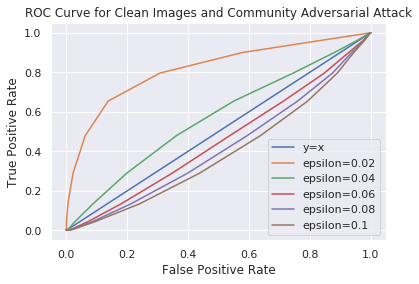

In [18]:
plt.plot(np.arange(0.0, 1.1, 0.1), np.arange(0.0, 1.1, 0.1), label="y=x")

# with h5py.File("../results/roc_curve_test_preprocessed_sampled.txt", 'r') as f:
#     tprs = f['tprs'][:]
#     fprs = f['fprs'][:]
#     print("Positives:", len(f['positive']))
#     print("Positives:", len(f['negative']))
# plt.plot(fprs, tprs, label="clean")
    

for epsilon in [0.02, 0.04, 0.06, 0.08, 0.1]:
    with h5py.File("../results/roc_curve_test_preprocessed_sampled_community_naive_same_epsilon_{}.txt".format(epsilon), 'r') as f:
        tprs = f['tprs'][:]
        fprs = f['fprs'][:]
    plt.plot(fprs, tprs, label="epsilon={}".format(epsilon))

plt.legend()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve for Clean Images and Community Adversarial Attack")

In [3]:
# with h5py.File("../results/roc_curve_test_preprocessed.txt", 'r') as f:
#     tprs = f['tprs'][:]
#     fprs = f['fprs'][:]
#     print("Positives:", len(f['positive']))
#     print("Positives:", len(f['negative']))

# plt.plot(fprs, tprs, label="clean")
# plt.plot(np.arange(0.0, 1.1, 0.1), np.arange(0.0, 1.1, 0.1), label="y=x")

# plt.ylabel("True Positive Rate")
# plt.xlabel("False Positive Rate")
# plt.title("ROC Curve for Clean Images on Full Dataset")
# plt.legend()

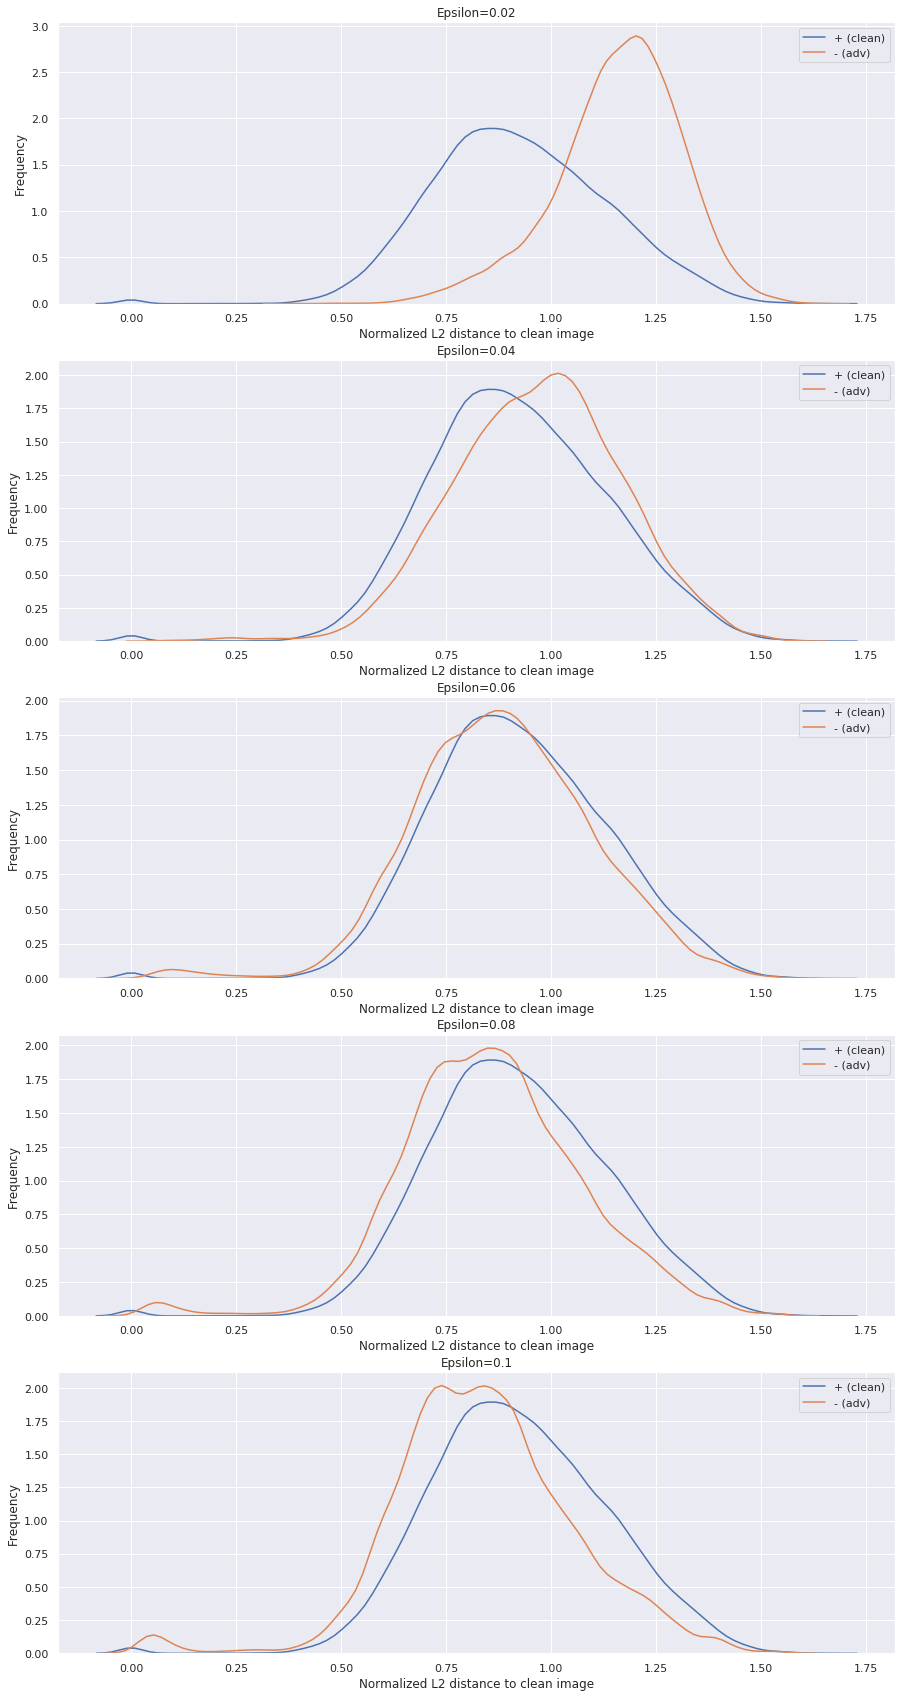

In [19]:
epsilons = [0.02, 0.04, 0.06, 0.08, 0.1]
fig, ax = plt.subplots(nrows=len(epsilons), ncols=1, figsize=(15, 30))

for indx, epsilon in enumerate(epsilons):
    with h5py.File(
        "../results/roc_curve_test_preprocessed_sampled_community_naive_same_epsilon_{}.txt".format(epsilon), 
        'r') as f:
        seaborn.distplot(
            f['positive'],
            kde=True,
            hist=False,
            label="+ (clean)",
            ax=ax[indx]
        )
        seaborn.distplot(
            f['negative'],
            kde=True,
            hist=False,
            label="- (adv)",
            ax=ax[indx]
        )
        ax[indx].set_xlabel("Normalized L2 distance to clean image")
        ax[indx].set_ylabel("Frequency")
        ax[indx].set_title("Epsilon={}".format(epsilon))

In [6]:
model = tf.keras.models.load_model("../keras-facenet/model/facenet_keras.h5")

In [5]:
def show_imgs(mod_imgs):
    rc = int(np.sqrt(len(mod_imgs)))
    fig, ax = plt.subplots(nrows=rc + 1, ncols=rc, figsize=(50, 50))

    i = 0
    for indx in range(rc + 1):
        for jndx in range(rc):
            if i >= len(mod_imgs):
                break
            ax[indx][jndx].axis("off")
            ax[indx][jndx].imshow(mod_imgs[i])
            i += 1

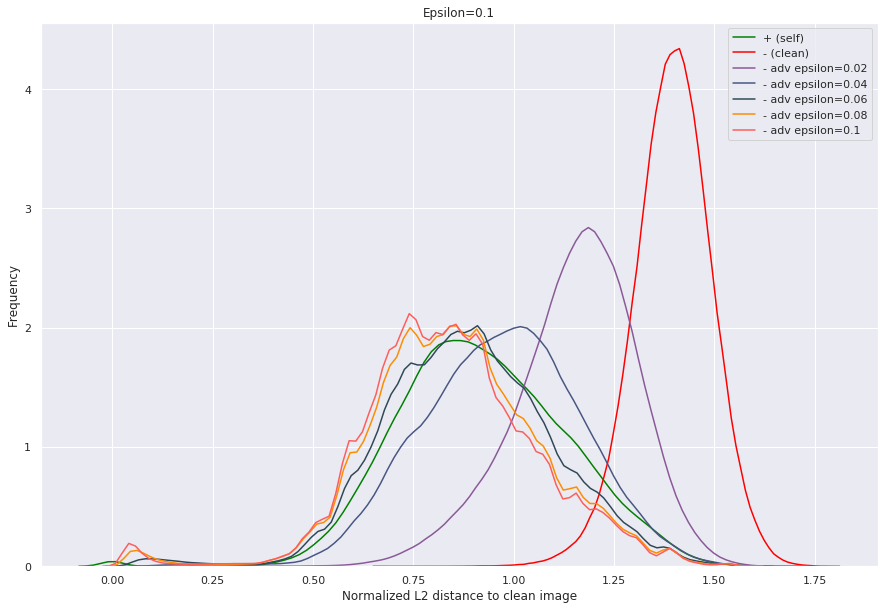

In [14]:
path_to_adversarial = "/data/vggface/test_perturbed_sampled/{true}/community_naive_same/{target}/epsilon_{epsilon}.h5"
path_to_clean = "/data/vggface/test_preprocessed_sampled/{id}/images.h5"
# modified_identity = "n001781"
# adversarial_target = "n009232"
epsilons = [0.02, 0.04, 0.06, 0.08, 0.1]

id2imnames = read_sampled_identities("../sampled_identities.txt")
identities = id2imnames.keys()
# identities = ["n001781", "n009232"]

positive = []
negative_clean = []
negative_adv = {eps: [] for eps in epsilons}

for adversarial_target in identities:
    clean_embeddings = []
    mod_embeddings = []
    adv = {eps: [] for eps in epsilons}
    
    with h5py.File(path_to_clean.format(id=adversarial_target), "r") as f:
        #     show_imgs(np.uint8(np.clip(f["images"][:], 0.0, 255.0)))
        clean_imgs = f["images"][:]
        clean_embeddings.extend(l2_normalize(model.predict(prewhiten(clean_imgs))))

    for modified_identity in identities:
        if modified_identity == adversarial_target:
            continue
        # the identity that was modified for the adversarial
        with h5py.File(path_to_clean.format(id=modified_identity), "r") as f:
        #     show_imgs(np.uint8(np.clip(f["images"][:], 0.0, 255.0)))
            mod_imgs = f["images"][:]
            mod_embeddings.extend(l2_normalize(model.predict(prewhiten(mod_imgs))))

        for indx, epsilon in enumerate(epsilons):
            with h5py.File(path_to_adversarial.format(
                target=adversarial_target,
                true=modified_identity,
                epsilon=epsilon
            ), "r") as f:
                adv_imgs = f["images"][:]
                adv[epsilon].extend(l2_normalize(model.predict(adv_imgs)))

    positive.extend(
        pairwise_distances(
            clean_embeddings, 
            clean_embeddings)[np.tril_indices(len(clean_embeddings), -1)].flatten()
    )
    negative_clean.extend(
        pairwise_distances(
            clean_embeddings, 
            mod_embeddings).flatten()
    )
    for indx, epsilon in enumerate(epsilons):
        negative_adv[epsilon].extend(
            pairwise_distances(clean_embeddings, adv[epsilon]).flatten()
        )

colors=['#8A5998',
        '#485682',
        '#2F4858',
        '#FD8D00',
        '#FD5E5B',
        '#D0528A',
       ]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
seaborn.distplot(
    positive,
    kde=True,
    hist=False,
    label="+ (self)",
    ax=ax,
    color='green'
)

seaborn.distplot(
    negative_clean,
    kde=True,
    hist=False,
    label="- (clean)",
    ax=ax,
    color='red'
)


for indx, epsilon in enumerate(epsilons):
    seaborn.distplot(
        negative_adv[epsilon],
        kde=True,
        hist=False,
        label="- adv epsilon={}".format(epsilon),
        ax=ax,
        color=colors[indx]
    )
    ax.set_xlabel("Normalized L2 distance to clean image")
    ax.set_ylabel("Frequency")
    ax.set_title("Epsilon={}".format(epsilon))

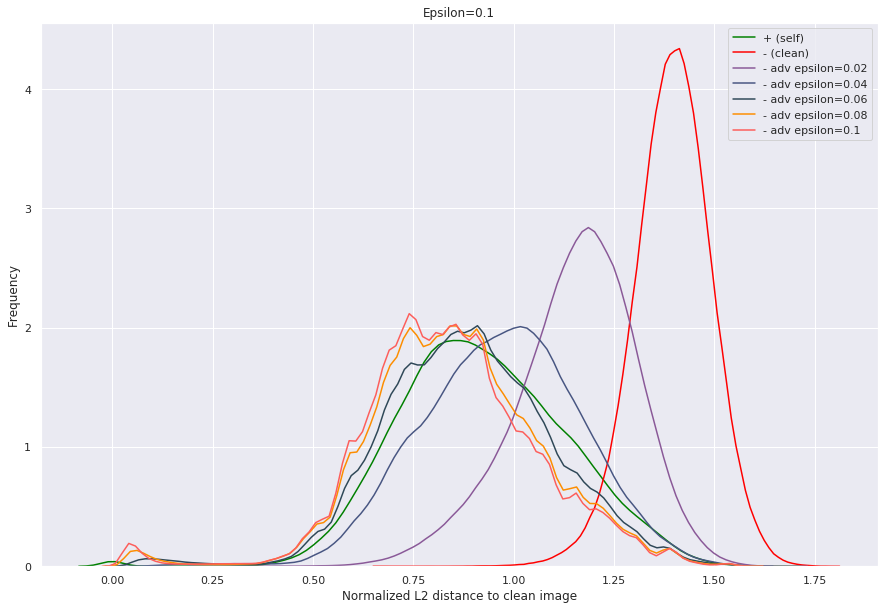

In [16]:
path_to_adversarial = "/data/vggface/test_perturbed_sampled/{true}/community_naive_same/{target}/epsilon_{epsilon}.h5"
path_to_clean = "/data/vggface/test_preprocessed_sampled/{id}/embeddings.h5"
# modified_identity = "n001781"
# adversarial_target = "n009232"
epsilons = [0.02, 0.04, 0.06, 0.08, 0.1]

id2imnames = read_sampled_identities("../sampled_identities.txt")
identities = id2imnames.keys()
# identities = ["n001781", "n009232"]

positive = []
negative_clean = []
negative_adv = {eps: [] for eps in epsilons}

for adversarial_target in identities:
    clean_embeddings = []
    mod_embeddings = []
    adv = {eps: [] for eps in epsilons}
    
    with h5py.File(path_to_clean.format(id=adversarial_target), "r") as f:
        #     show_imgs(np.uint8(np.clip(f["images"][:], 0.0, 255.0)))
        clean_embeddings.extend(f["embeddings"][:])

    for modified_identity in identities:
        if modified_identity == adversarial_target:
            continue
        # the identity that was modified for the adversarial
        with h5py.File(path_to_clean.format(id=modified_identity), "r") as f:
        #     show_imgs(np.uint8(np.clip(f["images"][:], 0.0, 255.0)))
            mod_embeddings.extend(f["embeddings"][:])

        for indx, epsilon in enumerate(epsilons):
            with h5py.File(path_to_adversarial.format(
                target=adversarial_target,
                true=modified_identity,
                epsilon=epsilon
            ), "r") as f:
                adv[epsilon].extend(f["embeddings"][:])

    positive.extend(
        pairwise_distances(
            clean_embeddings, 
            clean_embeddings)[np.tril_indices(len(clean_embeddings), -1)].flatten()
    )
    negative_clean.extend(
        pairwise_distances(
            clean_embeddings, 
            mod_embeddings).flatten()
    )
    for indx, epsilon in enumerate(epsilons):
        negative_adv[epsilon].extend(
            pairwise_distances(clean_embeddings, adv[epsilon]).flatten()
        )

colors=['#8A5998',
        '#485682',
        '#2F4858',
        '#FD8D00',
        '#FD5E5B',
        '#D0528A',
       ]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
seaborn.distplot(
    positive,
    kde=True,
    hist=False,
    label="+ (self)",
    ax=ax,
    color='green'
)

seaborn.distplot(
    negative_clean,
    kde=True,
    hist=False,
    label="- (clean)",
    ax=ax,
    color='red'
)


for indx, epsilon in enumerate(epsilons):
    seaborn.distplot(
        negative_adv[epsilon],
        kde=True,
        hist=False,
        label="- adv epsilon={}".format(epsilon),
        ax=ax,
        color=colors[indx]
    )
    ax.set_xlabel("Normalized L2 distance to clean image")
    ax.set_ylabel("Frequency")
    ax.set_title("Epsilon={}".format(epsilon))

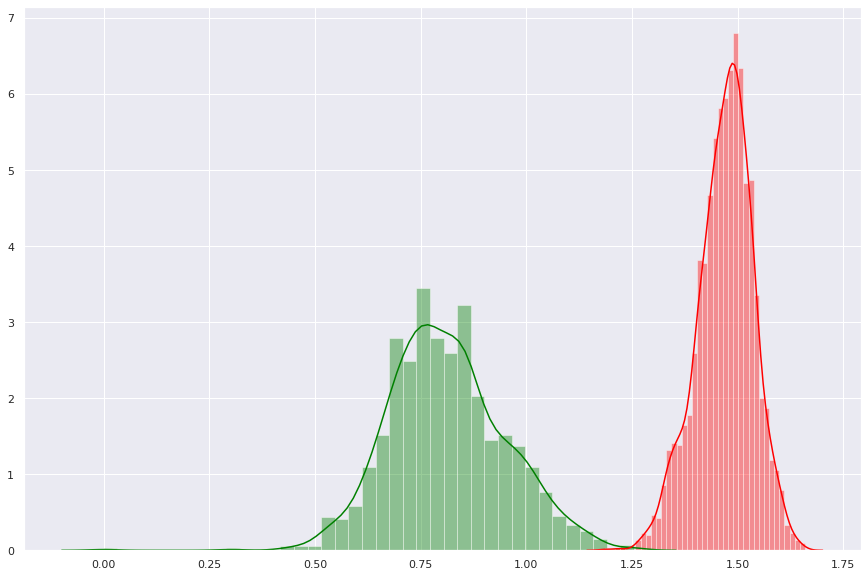

In [17]:
path_to_adversarial = "/data/vggface/test_perturbed_sampled/{true}/community_naive_same/{target}/epsilon_{epsilon}.h5"
path_to_clean = "/data/vggface/test_preprocessed_sampled/{id}/embeddings.h5"
modified_identity = "n001781"
adversarial_target = "n009232"
# epsilons = [0.02, 0.04, 0.06, 0.08, 0.1]
epsilons = [0.02, 0.04, 0.08]

with h5py.File(path_to_clean.format(id=adversarial_target), "r") as f:
    clean_embeddings = l2_normalize(f["embeddings"][:])

# the identity that was modified for the adversarial
with h5py.File(path_to_clean.format(id=modified_identity), "r") as f:
    mod_embeddings = l2_normalize(f["embeddings"][:])

adv = {}

for indx, epsilon in enumerate(epsilons):
    with h5py.File(path_to_adversarial.format(
        target=adversarial_target,
        true=modified_identity,
        epsilon=epsilon
    ), "r") as f:
        adv_imgs = f["images"][:]
        adv[epsilon] = l2_normalize(model.predict(adv_imgs))

positive = pairwise_distances(clean_embeddings, clean_embeddings)[np.tril_indices(len(clean_embeddings), -1)].flatten()
negative_clean = pairwise_distances(clean_embeddings, mod_embeddings).flatten()

colors=['#FD8D00',
        '#FD5E5B',
        '#D0528A',
        '#8A5998',
        '#485682',
        '#2F4858'
       ]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
seaborn.distplot(
    positive,
    kde=True,
    hist=True,
    label="+ (self)",
    ax=ax,
    color='green'
)

seaborn.distplot(
    negative_clean,
    kde=True,
    hist=True,
    label="- (clean)",
    ax=ax,
    color='red'
)


In [9]:
BOUNDING_BOXES = {}
with open("/data/vggface/bb_landmark/loose_bb_test.csv") as f:
    header = next(f)
    for l in f:
        l = l.strip("\n")
        name_id, x, y, w, h = l.split(",")
        name_id = name_id.strip("\"") + ".jpg"
        BOUNDING_BOXES[name_id] = (int(x), int(y), int(w), int(h))

id2imnames = read_sampled_identities("../sampled_identities.txt")

In [10]:
def load_crop_pillow_provided_landmarks(path):
    x, y, w, h = BOUNDING_BOXES[path]
    img = Image.open(os.path.join("/data/vggface/test", path))
    assert not (img is None)
    img = img.crop((x, y, x + w, y + h)) 
    return np.array(img.resize((160, 160)))

def sampled_embeddings_from_raw(identity, display=False):
    subj_images = np.array([load_crop_pillow_provided_landmarks(os.path.join(identity, x)) \
             for x in id2imnames[identity]])
    if display:
        show_imgs(np.clip(np.uint8(subj_images), 0, 255))
    return l2_normalize(model.predict(prewhiten(subj_images)))

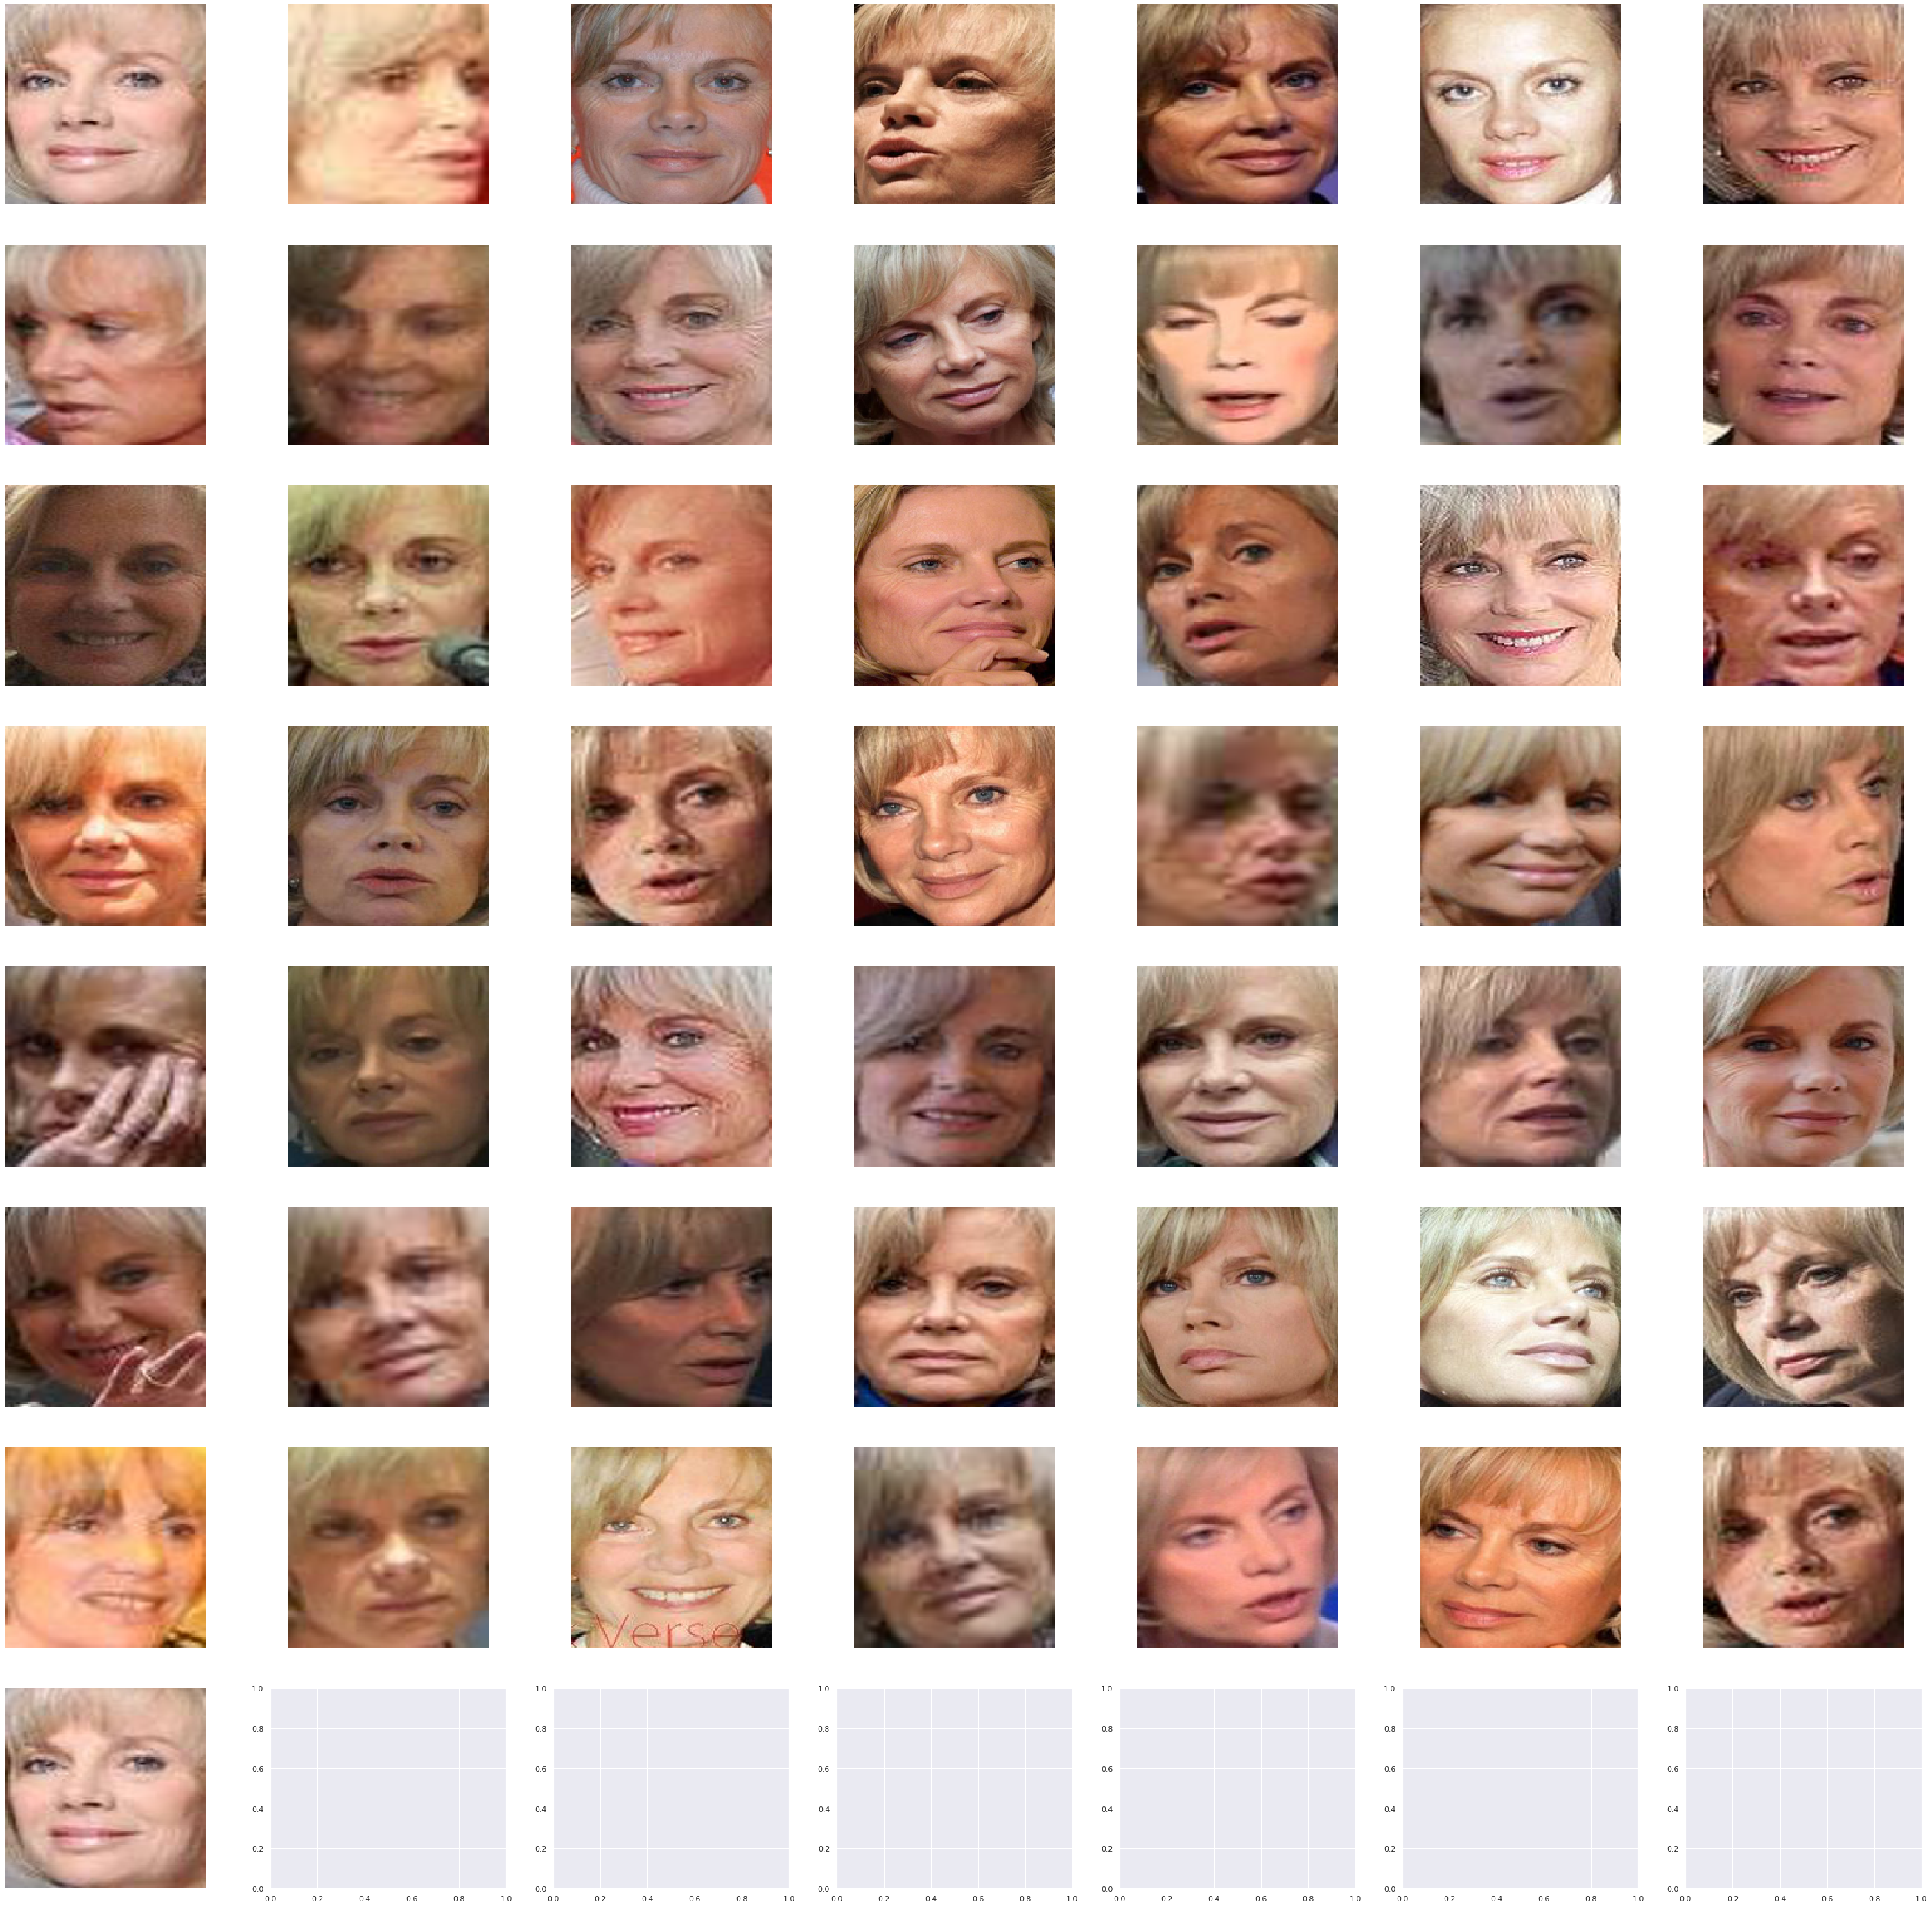

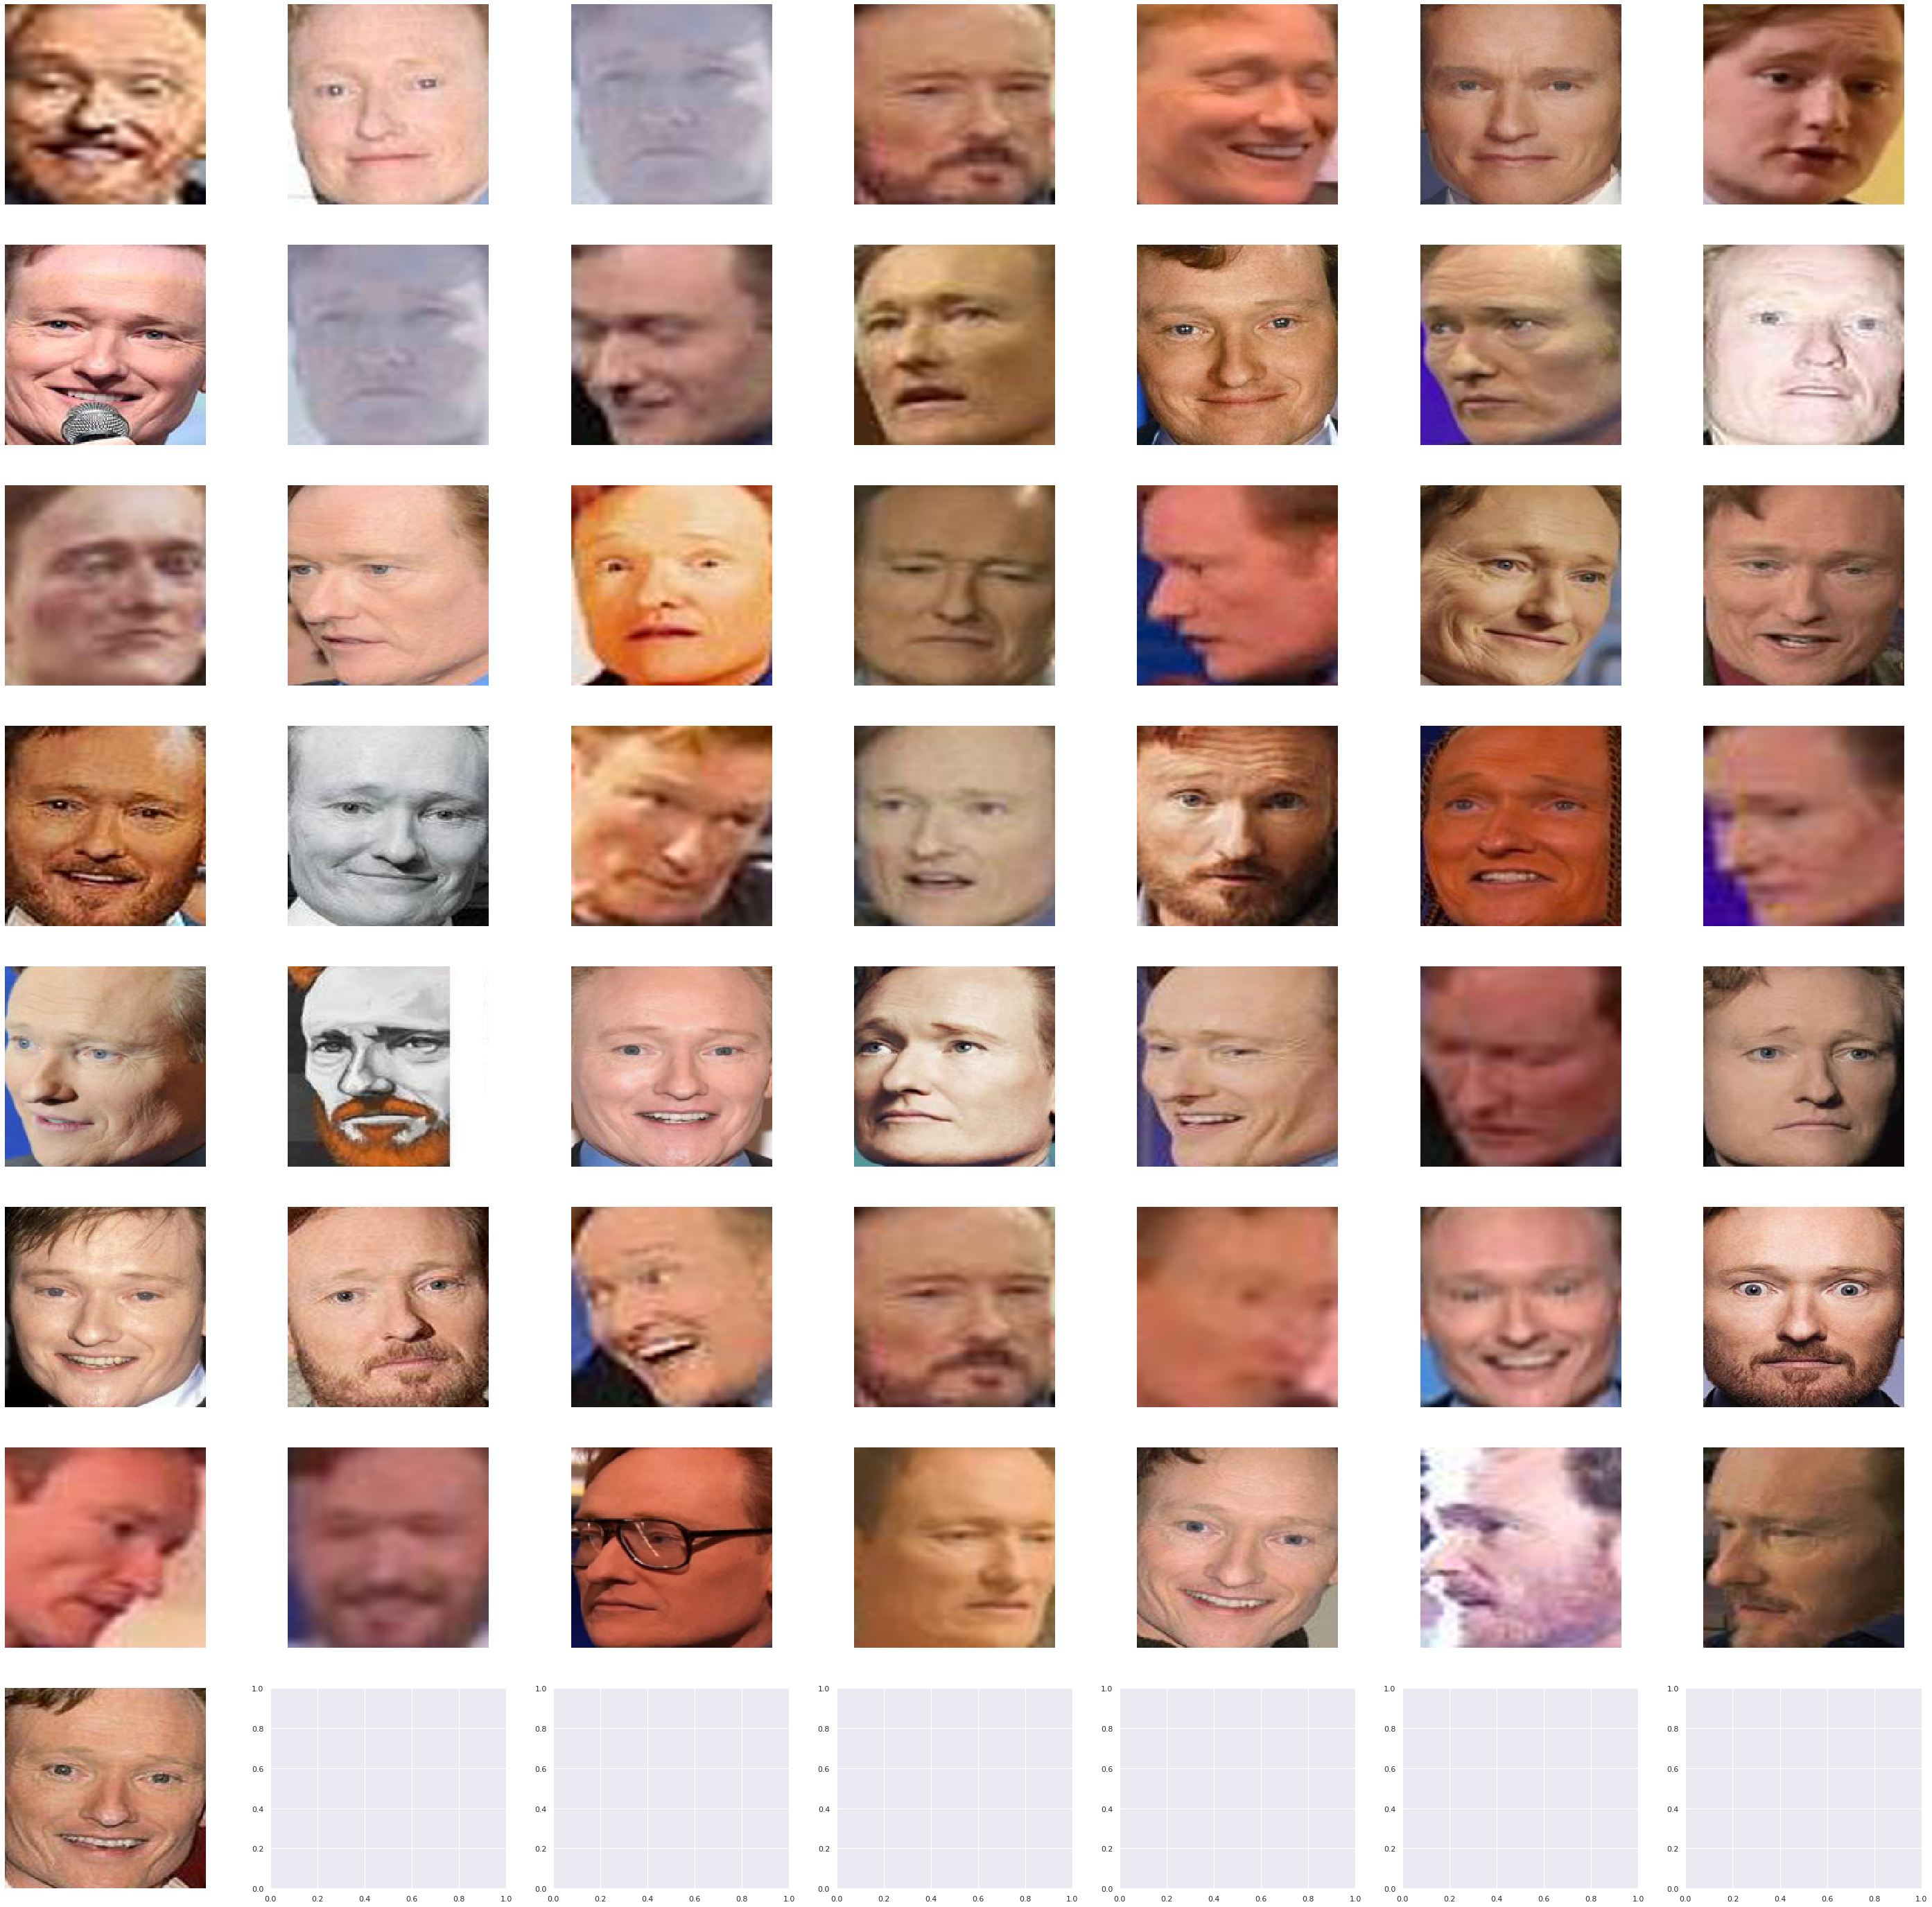

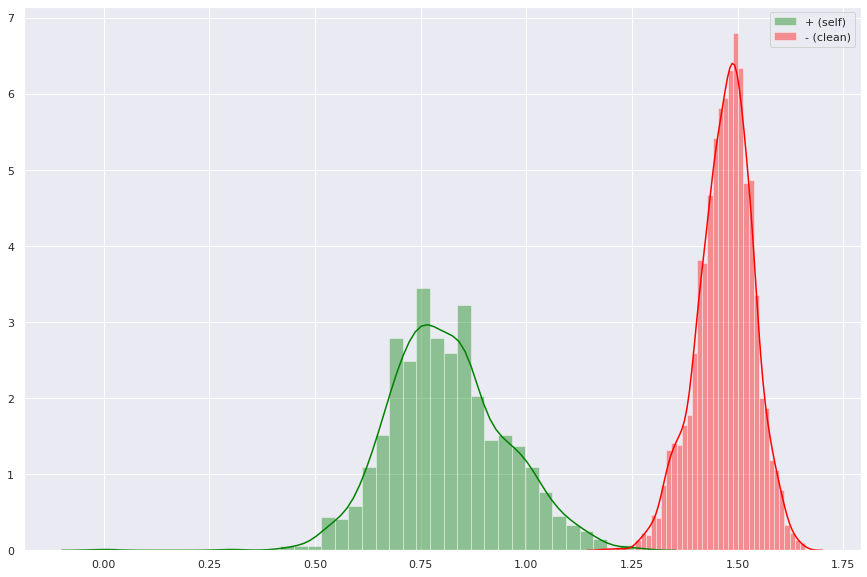

In [11]:
clean_raw = sampled_embeddings_from_raw(adversarial_target, display=True)
neg_raw = sampled_embeddings_from_raw(modified_identity, display=True)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
seaborn.distplot(
    pairwise_distances(clean_raw, clean_raw)[np.tril_indices(len(clean_raw), -1)].flatten(),
    kde=True,
    hist=True,
    label="+ (self)",
    ax=ax,
    color='green'
)

seaborn.distplot(
    pairwise_distances(clean_raw, neg_raw).flatten(),
    kde=True,
    hist=True,
    label="- (clean)",
    ax=ax,
    color='red'
)
plt.legend()